In [1]:
%run /Users/pnl0rc8b@emea.royalahold.net/Functions

In [2]:
ATTRIBUTEN = ["ndFiberIndex","ndAddedSugar","ndFreeOfAlcohol","ndSustainableProduced"]
ATTRIBUUT = ATTRIBUTEN[1]
 
#join alles
DF_merged_ = (DF_NLP_spark
              .join(DF_addedsugar, ["gtin", "gln"], how="left"))  # verander hier table naar bovengenoemde attribuut, zie notebook --> Functions

DF_merged_ = DF_merged_.drop_duplicates()

In [3]:
spark.conf.set("spark.sql.execution.arrow.enabled", "false")
DF_merged = DF_merged_.toPandas()
print("Shape van dataframe: ",(DF_merged["gln"].count(),len(DF_merged.columns)))

Shape van dataframe: (23449, 24)

In [4]:
# Fix empty fields van class_num
print(DF_merged["class_num_"+str(ATTRIBUUT)].isna().sum())
class_empty = DF_merged[DF_merged[str(ATTRIBUUT)].str.match('EMPTY', na=False)]
class_empty = class_empty["class_num_"+str(ATTRIBUUT)].tolist()

DF_merged.loc[DF_merged["class_num_"+str(ATTRIBUUT)].isnull(),["class_num_"+str(ATTRIBUUT)]] = DF_merged.loc[DF_merged["class_num_"+str(ATTRIBUUT)].isnull(),"class_num_"+str(ATTRIBUUT)].apply(lambda x: list(class_empty[0]))
print(DF_merged["class_num_"+str(ATTRIBUUT)].isna().sum())

658
0

FIBER 12240
SUGAR 6565
FAT 6510
FASAT 6533
CHOAVL 6498
PROTEINE 6512
SALT 6549
ENER_KJ 6286
ENER_Kcal 6283

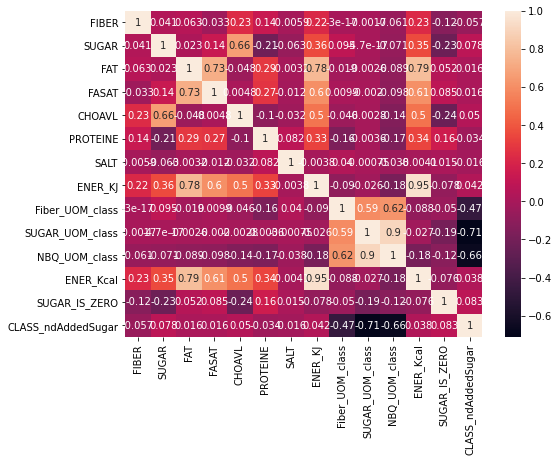

In [5]:
DF_merged = Correlation_matrix(DF_merged, ATTRIBUUT)

# Neural network NUMERICAL

## To array format

In [8]:
# FEATURES
X_train_df = DF_merged[['FIBER','SUGAR','FAT','FASAT','CHOAVL','PROTEINE','SALT','ENER_KJ',
                     'ENER_Kcal','FIBER_was_missing','SUGAR_was_missing','FAT_was_missing',
                     'FASAT_was_missing','CHOAVL_was_missing','PROTEINE_was_missing','SALT_was_missing',
                    'ENER_KJ_was_missing','Fiber_UOM_class','NBQ_UOM_class','SUGAR_UOM_class']]

if ATTRIBUUT == "ndFiberIndex":
    X_train_df = DF_merged[['FIBER','FIBER_was_missing','Fiber_UOM_class','PROTEINE']] # ndFiberIndex
if ATTRIBUUT == "ndAddedSugar":
    X_train_df = DF_merged[['SUGAR_was_missing','SUGAR_UOM_class','SUGAR']]
if ATTRIBUUT == "ndFreeOfAlcohol":
    X_train_df = DF_merged[['Fiber_UOM_class','NBQ_UOM_class','SUGAR_UOM_class']]
X_train_num = X_train_df.to_numpy()
print(X_train_num)

X_train_text_DF = DF_merged['padded_seq__EN'].tolist()
X_train_text = torch.FloatTensor(X_train_text_DF)
X_train_text = X_train_text.numpy()
vocab_size = np.amax(X_train_text)+1
print("Vocab size: ", vocab_size)

# TARGET
ytrain = DF_merged['class_num_'+ATTRIBUUT].tolist()
from collections import Counter
print(Counter(str(e) for e in ytrain))
ytrain_tensor = torch.FloatTensor(ytrain)
print(ytrain_tensor.shape)
ytrain = ytrain_tensor.numpy()

X_train = np.array(list(zip(X_train_num, X_train_text)))

[[ 0. 0. 26. ]
 [ 1. 1. 11.40487651]
 [ 1. 1. 11.40487651]
 ...
 [ 0. 0. 1.5 ]
 [ 0. 0. 0.7 ]
 [ 1. 1. 11.40487651]]
Vocab size: 41228.0
Counter({'[0, 0, 1]': 14129, '[0, 1, 0]': 4708, '[1, 0, 0]': 4612})
torch.Size([23449, 3])
<command-530963554874964>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 X_train = np.array(list(zip(X_train_num, X_train_text)))

## Split dataset in train / validatie / test

In [10]:
Xtrain, ytrain, Xval, yval, Xtest, ytest = split_train_test(X_train, ytrain)
print(Xtrain.shape, Xtest.shape, Xval.shape)
print(ytrain.shape, ytest.shape, yval.shape)

(18759, 2) (938, 2) (3752, 2)
(18759, 3) (938, 3) (3752, 3)

In [11]:
Xtrain_num, Xtrain_text, Xval_num, Xval_text, Xtest_num, Xtest_text = unzip_sets(Xtrain, Xval, Xtest)
Xtrain_num, Xtrain_text, Xval_num, Xval_text, Xtest_num, Xtest_text = to_tensor(Xtrain_num, Xtrain_text, Xval_num, 
                                                                                Xval_text, Xtest_num, Xtest_text)# To Tensor format

## Model

In [13]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Embedding, GlobalAveragePooling1D, Input, concatenate
from tensorflow.keras.optimizers import Adam, SGD, Adagrad

def build_model(hp):
    input_NUM = Input(shape=Xtrain_num.shape[1]) # Numerieke features
    input_TEXT = Input(shape=Xtrain_text.shape[1]) # Text features

    emb = Embedding(int(vocab_size), output_dim=20,input_length=Xtrain_text.shape[1])(input_TEXT)
    emb = Flatten()(emb)
    
    input_NUM = Dropout(0.3)(input_NUM)
    emb = Dropout(0.3)(emb)
    x = concatenate([emb, input_NUM])
    for i in range(hp.Int("n_layers", 1,3)):
        #activation_function = hp.Choice('activation',values=['relu','elu','tanh'])
        x = Dense(hp.Int(f"dense_{i}_units", min_value=5, max_value=100, step=5), activation='relu')(x)
    
    x = Dropout(0.3)(x)
    x = Dense(ytrain.shape[1], activation='softmax')(x)

    model = Model(inputs=[input_NUM , input_TEXT], outputs=[x])
    #model.summary()


    optimizer = hp.Choice('optimizer', values=['Adam', 'Adagrad', 'SGD'])
    if optimizer=='Adam':
        optimizer = Adam((hp.Choice('learning_rate',values=[ 1e-2, 8e-3, 6e-3, 4e-3, 2e-3, 1e-3])))
    if optimizer=='Adagrad':
        optimizer = Adam((hp.Choice('learning_rate',values=[ 1e-2, 8e-3, 6e-3, 4e-3, 2e-3, 1e-3])))
    if optimizer=='SGD':
        optimizer = Adam((hp.Choice('learning_rate',values=[ 1e-2, 8e-3, 6e-3, 4e-3, 2e-3, 1e-3])))
    #model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [14]:


#model_history = model.fit(Xtrain_text, ytrain, epochs=30, verbose=2, validation_data=(Xval_text, yval), shuffle=True)
#model_history = model.fit([Xtrain_num,Xtrain_text], ytrain, epochs=30, verbose=2, validation_data=([Xval_num,Xval_text], yval), shuffle=True)

In [15]:
!pip install keras-tuner
from tqdm.keras import TqdmCallback
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
import time

LOG_DIR = f"{int(time.time())}"

#tuner = RandomSearch(build_model, objective = "val_accuracy", max_trials=30, executions_per_trial=1, directory=LOG_DIR)
#tuner = Hyperband(build_model, objective = "val_accuracy", hyperband_iterations=30, max_epochs=1, directory=LOG_DIR)
tuner = BayesianOptimization(build_model, objective = "val_accuracy", max_trials=30,directory=LOG_DIR)

tuner.search(x=[Xtrain_num,Xtrain_text], y=ytrain, epochs=1, batch_size=32, validation_data=([Xval_num,Xval_text], yval))

Requirement already satisfied: keras-tuner in /databricks/python3/lib/python3.8/site-packages (1.1.2)
Requirement already satisfied: tensorboard in /databricks/python3/lib/python3.8/site-packages (from keras-tuner) (2.8.0)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from keras-tuner) (1.20.1)
Requirement already satisfied: ipython in /databricks/python3/lib/python3.8/site-packages (from keras-tuner) (7.22.0)
Requirement already satisfied: kt-legacy in /databricks/python3/lib/python3.8/site-packages (from keras-tuner) (1.0.4)
Requirement already satisfied: requests in /databricks/python3/lib/python3.8/site-packages (from keras-tuner) (2.25.1)
Requirement already satisfied: packaging in /databricks/python3/lib/python3.8/site-packages (from keras-tuner) (20.9)
Requirement already satisfied: backcall in /databricks/python3/lib/python3.8/site-packages (from ipython->keras-tuner) (0.2.0)
Requirement already satisfied: prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0 in /databricks/python3/lib/python3.8/site-packages (from ipython->keras-tuner) (3.0.17)
Requirement already satisfied: pygments in /databricks/python3/lib/python3.8/site-packages (from ipython->keras-tuner) (2.8.1)
Requirement already satisfied: pexpect>4.3 in /databricks/python3/lib/python3.8/site-packages (from ipython->keras-tuner) (4.8.0)
Requirement already satisfied: decorator in /databricks/python3/lib/python3.8/site-packages (from ipython->keras-tuner) (5.0.6)
Requirement already satisfied: jedi>=0.16 in /databricks/python3/lib/python3.8/site-packages (from ipython->keras-tuner) (0.17.2)
Requirement already satisfied: traitlets>=4.2 in /databricks/python3/lib/python3.8/site-packages (from ipython->keras-tuner) (5.0.5)
Requirement already satisfied: pickleshare in /databricks/python3/lib/python3.8/site-packages (from ipython->keras-tuner) (0.7.5)
Requirement already satisfied: setuptools>=18.5 in /usr/local/lib/python3.8/dist-packages (from ipython->keras-tuner) (52.0.0)
Requirement already satisfied: parso<0.8.0,>=0.7.0 in /databricks/python3/lib/python3.8/site-packages (from jedi>=0.16->ipython->keras-tuner) (0.7.0)
Requirement already satisfied: ptyprocess>=0.5 in /databricks/python3/lib/python3.8/site-packages (from pexpect>4.3->ipython->keras-tuner) (0.7.0)
Requirement already satisfied: wcwidth in /databricks/python3/lib/python3.8/site-packages (from prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0->ipython->keras-tuner) (0.2.5)
Requirement already satisfied: ipython-genutils in /databricks/python3/lib/python3.8/site-packages (from traitlets>=4.2->ipython->keras-tuner) (0.2.0)
Requirement already satisfied: pyparsing>=2.0.2 in /databricks/python3/lib/python3.8/site-packages (from packaging->keras-tuner) (2.4.7)
Requirement already satisfied: certifi>=2017.4.17 in /databricks/python3/lib/python3.8/site-packages (from requests->keras-tuner) (2020.12.5)
Requirement already satisfied: chardet<5,>=3.0.2 in /databricks/python3/lib/python3.8/site-packages (from requests->keras-tuner) (4.0.0)
Requirement already satisfied: urllib3<1.27,>=1.21.1 in /databricks/python3/lib/python3.8/site-packages (from requests->keras-tuner) (1.25.11)
Requirement already satisfied: idna<3,>=2.5 in /databricks/python3/lib/python3.8/site-packages (from requests->keras-tuner) (2.10)
Requirement already satisfied: absl-py>=0.4 in /databricks/python3/lib/python3.8/site-packages (from tensorboard->keras-tuner) (1.0.0)
Requirement already satisfied: protobuf>=3.6.0 in /databricks/python3/lib/python3.8/site-packages (from tensorboard->keras-tuner) (3.17.2)
Requirement already satisfied: werkzeug>=0.11.15 in /databricks/python3/lib/python3.8/site-packages (from tensorboard->keras-tuner) (2.1.2)
Requirement already satisfied: google-auth<3,>=1.6.3 in /databricks/python3/lib/python3.8/site-packages (from tensorboard->keras-tuner) (2.6.6)
Requirement already satisfied: google-auth-oauthlib<0.5,>=0.4.1 in /databricks/python3/lib/pyt